## Antiguo proyecto de Redes Neuronales Recurrentes usando audios .wav, obteniendo su MFCC, aplicandolos a una RNN y validandolo con k fold cross validation

#### Librerias

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import librosa
import librosa.display
import os
import soundfile as sf
import json
import random
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

from keras import Sequential
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

import datetime
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping
random.seed(0)

#### Funciones a usar

In [2]:
#Obtiene el path con el nombre de todos los archivos de un directorio.
def get_files_from_path(directory):
    path_files = []
    dir_list = os.listdir(directory)
    for path in dir_list:
        path_files.append(directory+"\\"+path)
    return path_files


#Extrae los paths que cumplan con un codigo
def extract_paths_for_emotions_keys(emotions_code, files_path, get_code):
    paths = []
    emotions_set = set(emotions_code)
    for code_file in files_path:
        if (get_code(code_file) in emotions_set):
            paths.append(code_file)
    return paths


#Obtiene el codigo en el nombre del archivo para el dataset CREMA-D
def get_code_crema_d(path):
    return path[119:122]


#Obtiene el codigo en el nombre del archivo para el dataset SAVEE
def get_code_savee(path):
    return path[108]


#Esta función abre el archivo .wav y obtiene el mfcc escalado en un vector de 40 elementos.
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features


#Esta función permite guardar los MFCC en 'features', el código en 'code' y su dirección en 'path' en un archivo json. 
def save_elements_in_json(examples_saved, name):
    json_files = []
    json_file = {}
    index = 0
    for file in examples_saved:
        json_file = {"id": index, "features":[str(elem) for elem in file[0]] ,"code":file[1], "path":file[2]}
        json_files.append(json_file)
        index += 1
    json_object = json.dumps(json_files)
    with open(f"{name}.json", "w") as outfile:
        outfile.write(json_object)
   

#La función permite cargar datos del MFCC y código desde un archivo json.
def load_elements_from_json(name):
    f = open(f'{name}.json')
    data = json.load(f)
    examples = []
    for element in data:
        examples.append(([float(feature) for feature in (element["features"])], element["code"]))
    return examples


#La función nos permite devolver una lista de MFCC obtenidos de una lista de paths. 
#El MFCC tiene un límite que no le permite cargar archivos menor o igual a 44 kb.
#Con el diccionario obtenemos el total de audios recuperados por emoción.
def get_features(paths,get_code, files_filters = dict()):
    examples = []
    for path in paths:
        code = get_code(path)
        file_stats = os.stat(path)
        if (file_stats.st_size > 44):
            feature = features_extractor(path)
            files_filters[code]+= 1
            examples.append((feature,code))
    print(f"Se obtuvo el MFCC de unos {len(paths)} sobre {sum(files_filters[files] for files in files_filters)} audios.")
    return examples


#Selecciona n ejemplos que necesitemos y los mezcla.
def select_elements(examples, code, quantity, new_code):
    random.shuffle(examples)
    elements = []
    counter = 1
    for example in examples:
        if (counter > quantity):
            break
        if code == example[1]:
            elements.append((example[0],new_code))
            counter = counter + 1
    return elements

Los siguientes bloques obtienen los paths y filtra las emociones que necesitemos en cada dataset (CREMA-D y SAVEE).

#### Funciones para obtener los datos 

In [3]:
#Obtiene todos los datos de CREMA-D y SAVEE para un  
def get_datas():
    files_path = get_files_from_path(f"{os.getcwd()}\\..\\..\\Datasets\\AudioWav")
    emotions_code = ["NEU", "FEA","ANG"]
    datas_files = extract_paths_for_emotions_keys(emotions_code, files_path, get_code_crema_d)
    files_path_s = get_files_from_path(f"{os.getcwd()}\\..\\..\\Datasets\\ALL")
    emotions_code_s = ["a", "f","n"]
    datas_files_s = extract_paths_for_emotions_keys(emotions_code_s, files_path_s, get_code_savee) 
    examples = []
    files_filters = dict()
    files_filters["NEU"] = 0
    files_filters["FEA"] = 0
    files_filters["ANG"] = 0
    files_filters["a"] = 0
    files_filters["f"] = 0
    files_filters["n"] = 0
    examples = get_features(datas_files, get_code_crema_d, files_filters)
    examples_s = get_features(datas_files_s, get_code_savee, files_filters)
    return examples + examples_s

#Obtiene los datos de entrada para la red neuronal x: mfcc normalizados, y: labeles categorizados
def get_entries():
    all_examples = get_datas()
    entries = []
    for example in all_examples:
        entries.append((example[0], example[1]))
    '''
    datas = select_elements(entries, 'NEU', 896,"without_stress")
    datas += select_elements(entries, 'ANG', 550, "stress")
    datas += select_elements(entries, 'FEA', 550, "stress")
    datas += select_elements(entries, 'a', 60, "stress")
    datas += select_elements(entries, 'f', 60, "stress")
    datas += select_elements(entries, 'n', 120, "without_stress")
    '''
    datas = select_elements(entries, 'NEU', 1087,"without_stress")
    datas += select_elements(entries, 'ANG', 1271, "stress")
    datas += select_elements(entries, 'FEA', 1270, "stress")
    datas += select_elements(entries, 'a', 60, "stress")
    datas += select_elements(entries, 'f', 60, "stress")
    datas += select_elements(entries, 'n', 120, "without_stress")   
    random.shuffle(datas)
    X = []
    y = []
    for data in datas:
        X.append(data[0])
        y.append(data[1])
    labelencoder=preprocessing.LabelEncoder()
    y = to_categorical(labelencoder.fit_transform(y))
    return X, y

#Obtiene los datos divididos de entrenamiento y tests
def obtain_datas_train_and_test(percentage):
    X, y = get_entries()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =percentage,random_state=0)
    y = np.array(y)
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    return X_train, X_test, y_train, y_test

In [4]:
X_train, X_test, y_train, y_test = obtain_datas_train_and_test(0.8)
num_labels = y_train.shape[1] + y_test.shape[1]
dim_entrada = (X_train.shape[1],1)

Se obtuvo el MFCC de unos 3629 sobre 3628 audios.
Se obtuvo el MFCC de unos 240 sobre 3868 audios.


In [29]:
#funciones de redes neuronales
def previous_RNN():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

def new_RNN_a():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model
'''
Cross-validated score (Accuracy score): 0.7987477638640429
-----------------------
Resumen
Fold score (Accuracy score): 0.8102678571428571
Fold score (Accuracy score): 0.7516778523489933
Fold score (Accuracy score): 0.7740492170022372
Fold score (Accuracy score): 0.8232662192393736
Fold score (Accuracy score): 0.8344519015659956
'''
def new_RNN_b():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.8090339892665475
-----------------------
Resumen
Fold score (Accuracy score): 0.8214285714285714
Fold score (Accuracy score): 0.785234899328859
Fold score (Accuracy score): 0.8008948545861297
Fold score (Accuracy score): 0.8098434004474273
Fold score (Accuracy score): 0.8277404921700223
'''

def new_RNN_c():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.7))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.7754919499105546
-----------------------
Resumen
Fold score (Accuracy score): 0.7879464285714286
Fold score (Accuracy score): 0.7539149888143176
Fold score (Accuracy score): 0.7718120805369127
Fold score (Accuracy score): 0.7628635346756152
Fold score (Accuracy score): 0.8008948545861297
'''

def double_lstm():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.7920393559928444
-----------------------
Resumen
Fold score (Accuracy score): 0.78125
Fold score (Accuracy score): 0.767337807606264
Fold score (Accuracy score): 0.8008948545861297
Fold score (Accuracy score): 0.7941834451901566
Fold score (Accuracy score): 0.8165548098434005
'''

#fail tarda mucho
def triple_lstm():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.7991949910554562
-----------------------
Resumen
Fold score (Accuracy score): 0.7991071428571429
Fold score (Accuracy score): 0.785234899328859
Fold score (Accuracy score): 0.814317673378076
Fold score (Accuracy score): 0.7762863534675615
Fold score (Accuracy score): 0.8210290827740492
'''
def dense_Layer():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Dense(50))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.7844364937388193
-----------------------
Resumen
Fold score (Accuracy score): 0.7589285714285714
Fold score (Accuracy score): 0.7740492170022372
Fold score (Accuracy score): 0.796420581655481
Fold score (Accuracy score): 0.785234899328859
Fold score (Accuracy score): 0.8076062639821029
'''

def possible_RNN():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(Activation('relu'))
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model
'''
Cross-validated score (Accuracy score): 0.7898032200357782
-----------------------
Resumen
Fold score (Accuracy score): 0.7834821428571429
Fold score (Accuracy score): 0.8299776286353467
Fold score (Accuracy score): 0.767337807606264
Fold score (Accuracy score): 0.7472035794183445
Fold score (Accuracy score): 0.8210290827740492
'''
def activation_RNN():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Activation('relu'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.802772808586762
-----------------------
Resumen
Fold score (Accuracy score): 0.8080357142857143
Fold score (Accuracy score): 0.8076062639821029
Fold score (Accuracy score): 0.8008948545861297
Fold score (Accuracy score): 0.767337807606264
Fold score (Accuracy score): 0.8299776286353467
'''
def double_dropout():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Dropout(0.5))
    #model.add(Activation('relu'))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.8019136281355056
-----------------------
Resumen
Fold score (Accuracy score): 0.7945736434108527
Fold score (Accuracy score): 0.8036175710594315
Fold score (Accuracy score): 0.7800776196636481
Fold score (Accuracy score): 0.815006468305304
Fold score (Accuracy score): 0.8163001293661061
'''
def double_dropout_activation():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.7944142746314973
-----------------------
Resumen
Fold score (Accuracy score): 0.7622739018087855
Fold score (Accuracy score): 0.810077519379845
Fold score (Accuracy score): 0.7865459249676585
Fold score (Accuracy score): 0.8020698576972833
Fold score (Accuracy score): 0.8111254851228978
'''
def double_RNN():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(LSTM(units=25,input_shape= dim_entrada, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model
'''
Cross-validated score (Accuracy score): 0.8057926040858546
-----------------------
Resumen
Fold score (Accuracy score): 0.7958656330749354
Fold score (Accuracy score): 0.789405684754522
Fold score (Accuracy score): 0.7878395860284605
Fold score (Accuracy score): 0.8279430789133247
Fold score (Accuracy score): 0.8279430789133247
'''

def basic():
    dropout = 0.5
    model = Sequential()
    model.add(LSTM(50,input_shape= dim_entrada))
    model.add(Dense(2,activation = 'sigmoid'))

    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
    return model
'''
Cross-validated score (Accuracy score): 0.8047582104990949
-----------------------
Resumen
Fold score (Accuracy score): 0.7984496124031008
Fold score (Accuracy score): 0.8126614987080103
Fold score (Accuracy score): 0.7813712807244502
Fold score (Accuracy score): 0.8227684346701164
Fold score (Accuracy score): 0.8085381630012937

'''

def new_RNN():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(LSTM(units=20,input_shape= dim_entrada, return_sequences=True))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(LSTM(units=10,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
model = Sequential()
model.add(layers.Embedding(input_dim=20000, 
                           output_dim=100, 
                           input_length=300))
model.add(layers.Bidirectional(layers.LSTM(100, dropout=0.5, 
                                           recurrent_dropout=0.5, 
                                           return_sequences=True)))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=opt, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()
'''
'''
Cross-validated score (Accuracy score): 0.7929338103756708
-----------------------
Resumen
Fold score (Accuracy score): 0.7901785714285714
Fold score (Accuracy score): 0.8277404921700223
Fold score (Accuracy score): 0.7897091722595079
Fold score (Accuracy score): 0.7472035794183445
Fold score (Accuracy score): 0.8098434004474273
2
#https://keras.io/api/callbacks/early_stopping/
'''


'\nCross-validated score (Accuracy score): 0.7929338103756708\n-----------------------\nResumen\nFold score (Accuracy score): 0.7901785714285714\nFold score (Accuracy score): 0.8277404921700223\nFold score (Accuracy score): 0.7897091722595079\nFold score (Accuracy score): 0.7472035794183445\nFold score (Accuracy score): 0.8098434004474273\n2\n#https://keras.io/api/callbacks/early_stopping/\n'

In [30]:
model = new_RNN()
model.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 40, 50)            10400     
                                                                 
 activation_126 (Activation)  (None, 40, 50)           0         
                                                                 
 dropout_52 (Dropout)        (None, 40, 50)            0         
                                                                 
 lstm_59 (LSTM)              (None, 40, 20)            5680      
                                                                 
 activation_127 (Activation)  (None, 40, 20)           0         
                                                                 
 dropout_53 (Dropout)        (None, 40, 20)            0         
                                                                 
 lstm_60 (LSTM)              (None, 10)              

In [16]:
k_fold = KFold(5)
fold = 0
y_tests = []
predictions = []
scores = []
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))
for train, test in k_fold.split(X):
    fold = fold + 1
    print(f"Fold #{fold}")
    X_train = X[train]
    X_test = X[test]
    y_train = y[train]
    y_test = y[test]
    print(f"Train - X:{X_train.shape} y:{y_train.shape}")
    print(f"Test - X:{X_test.shape} y:{y_test.shape}")
    
    num_labels = y.shape[1]
    dim_entrada = (X_train.shape[1],1)

    #model = new_RNN()
    model = new_RNN()
    callbacks = []
    '''
    callbacks = [
    EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=20,
            verbose=1,
        )
    ]
    '''
    num_epochs = 200
    num_batch_size = 32
    start = datetime.datetime.now()
   
    results = model.fit(X_train, y_train, batch_size=num_batch_size,epochs=num_epochs, validation_data=(X_test, y_test),callbacks=callbacks)

    pred = model.predict(X_test)
    y_tests.append(y_test)
    pred=[([1,0] if i[0]>i[1] else [0,1]) for i in pred]
    predictions.append(pred)
    score = metrics.accuracy_score(pred, y_test)
    math = confusion_matrix([(1 if x[0]==1 else 0) for x in pred],[(1 if x[0]==1 else 0) for x in y_test], labels=[1,0])
    scores.append([score])
    print(f"Fold score (Accuracy score): {score}")
    print("Matriz de confusion")
    print("-------------------")
    print("---------| Verdadero | Falso |")
    print(f"Verdadero|  {math[0][0]}        {math[0][1]}")
    print(f"Falso    |  {math[1][0]}        {math[1][1]}")

y_tests = np.concatenate(y_tests)
predictions = np.concatenate(predictions)
score = metrics.accuracy_score(predictions, y_tests)
print("-----------------------")
print(f"Cross-validated score (Accuracy score): {score}")
print("-----------------------")
print("Resumen")
for result in scores:
    print(f"Fold score (Accuracy score): {result[0]}")
    
#https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_05_2_kfold.ipynb
#https://www.youtube.com/watch?v=maiQf8ray_s

Fold #1
Train - X:(3093, 40) y:(3093, 2)
Test - X:(774, 40) y:(774, 2)
Epoch 1/200
97/97 [==============================] - 12s 46ms/step - loss: 0.6087 - accuracy: 0.6899 - val_loss: 0.5811 - val_accuracy: 0.6615
Epoch 2/200
97/97 [==============================] - 3s 31ms/step - loss: 0.5429 - accuracy: 0.7068 - val_loss: 0.5285 - val_accuracy: 0.7041
Epoch 3/200
97/97 [==============================] - 3s 34ms/step - loss: 0.5205 - accuracy: 0.7087 - val_loss: 0.5239 - val_accuracy: 0.7067
Epoch 4/200
97/97 [==============================] - 3s 31ms/step - loss: 0.5019 - accuracy: 0.7009 - val_loss: 0.5182 - val_accuracy: 0.6977
Epoch 5/200
97/97 [==============================] - 3s 32ms/step - loss: 0.4941 - accuracy: 0.7207 - val_loss: 0.5058 - val_accuracy: 0.7171
Epoch 6/200
97/97 [==============================] - 3s 31ms/step - loss: 0.4929 - accuracy: 0.7262 - val_loss: 0.4991 - val_accuracy: 0.7183
Epoch 7/200
97/97 [==============================] - 3s 27ms/step - loss: 0.

Epoch 58/200
97/97 [==============================] - 3s 31ms/step - loss: 0.3770 - accuracy: 0.8054 - val_loss: 0.4079 - val_accuracy: 0.7765
Epoch 59/200
97/97 [==============================] - 3s 32ms/step - loss: 0.3484 - accuracy: 0.8193 - val_loss: 0.4306 - val_accuracy: 0.7674
Epoch 60/200
97/97 [==============================] - 3s 31ms/step - loss: 0.3635 - accuracy: 0.8118 - val_loss: 0.4066 - val_accuracy: 0.7907
Epoch 61/200
97/97 [==============================] - 3s 31ms/step - loss: 0.3490 - accuracy: 0.8235 - val_loss: 0.4489 - val_accuracy: 0.7481
Epoch 62/200
97/97 [==============================] - 3s 32ms/step - loss: 0.3443 - accuracy: 0.8189 - val_loss: 0.5464 - val_accuracy: 0.7687
Epoch 63/200
97/97 [==============================] - 3s 31ms/step - loss: 0.3533 - accuracy: 0.8231 - val_loss: 0.5508 - val_accuracy: 0.7661
Epoch 64/200
97/97 [==============================] - 3s 33ms/step - loss: 0.3416 - accuracy: 0.8248 - val_loss: 0.4320 - val_accuracy: 0.7739

97/97 [==============================] - 3s 32ms/step - loss: 0.2883 - accuracy: 0.8600 - val_loss: 0.5202 - val_accuracy: 0.7610
Epoch 116/200
97/97 [==============================] - 3s 31ms/step - loss: 0.2551 - accuracy: 0.8736 - val_loss: 0.5244 - val_accuracy: 0.7649
Epoch 117/200
97/97 [==============================] - 3s 32ms/step - loss: 0.2766 - accuracy: 0.8636 - val_loss: 0.5608 - val_accuracy: 0.7726
Epoch 118/200
97/97 [==============================] - 3s 32ms/step - loss: 0.2473 - accuracy: 0.8801 - val_loss: 0.5531 - val_accuracy: 0.7894
Epoch 119/200
97/97 [==============================] - 3s 32ms/step - loss: 0.2488 - accuracy: 0.8768 - val_loss: 0.5010 - val_accuracy: 0.7597
Epoch 120/200
97/97 [==============================] - 3s 32ms/step - loss: 0.2389 - accuracy: 0.8826 - val_loss: 0.5735 - val_accuracy: 0.7636
Epoch 121/200
97/97 [==============================] - 3s 31ms/step - loss: 0.2401 - accuracy: 0.8784 - val_loss: 0.6164 - val_accuracy: 0.7739
Epoch 

Epoch 172/200
97/97 [==============================] - 3s 31ms/step - loss: 0.1577 - accuracy: 0.9256 - val_loss: 0.9848 - val_accuracy: 0.7933
Epoch 173/200
97/97 [==============================] - 3s 29ms/step - loss: 0.2051 - accuracy: 0.9085 - val_loss: 0.8251 - val_accuracy: 0.7700
Epoch 174/200
97/97 [==============================] - 3s 31ms/step - loss: 0.1573 - accuracy: 0.9282 - val_loss: 0.7776 - val_accuracy: 0.7700
Epoch 175/200
97/97 [==============================] - 3s 30ms/step - loss: 0.1458 - accuracy: 0.9382 - val_loss: 0.8107 - val_accuracy: 0.7972
Epoch 176/200
97/97 [==============================] - 3s 32ms/step - loss: 0.3215 - accuracy: 0.8542 - val_loss: 0.6176 - val_accuracy: 0.7700
Epoch 177/200
97/97 [==============================] - 3s 33ms/step - loss: 0.1829 - accuracy: 0.9176 - val_loss: 0.8226 - val_accuracy: 0.7804
Epoch 178/200
97/97 [==============================] - 3s 31ms/step - loss: 0.1728 - accuracy: 0.9201 - val_loss: 0.9238 - val_accuracy:

97/97 [==============================] - 3s 29ms/step - loss: 0.3953 - accuracy: 0.7737 - val_loss: 0.4165 - val_accuracy: 0.7468
Epoch 28/200
97/97 [==============================] - 3s 26ms/step - loss: 0.3988 - accuracy: 0.7685 - val_loss: 0.4271 - val_accuracy: 0.7494
Epoch 29/200
97/97 [==============================] - 3s 26ms/step - loss: 0.4191 - accuracy: 0.7672 - val_loss: 0.4286 - val_accuracy: 0.7597
Epoch 30/200
97/97 [==============================] - 2s 24ms/step - loss: 0.4010 - accuracy: 0.7759 - val_loss: 0.4199 - val_accuracy: 0.7597
Epoch 31/200
97/97 [==============================] - 2s 26ms/step - loss: 0.4087 - accuracy: 0.7653 - val_loss: 0.4090 - val_accuracy: 0.7506
Epoch 32/200
97/97 [==============================] - 2s 26ms/step - loss: 0.3949 - accuracy: 0.7779 - val_loss: 0.4213 - val_accuracy: 0.7661
Epoch 33/200
97/97 [==============================] - 2s 24ms/step - loss: 0.4059 - accuracy: 0.7662 - val_loss: 0.4120 - val_accuracy: 0.7687
Epoch 34/200

97/97 [==============================] - 2s 25ms/step - loss: 0.3033 - accuracy: 0.8393 - val_loss: 0.3796 - val_accuracy: 0.8075
Epoch 85/200
97/97 [==============================] - 2s 25ms/step - loss: 0.3279 - accuracy: 0.8222 - val_loss: 0.3785 - val_accuracy: 0.7959
Epoch 86/200
97/97 [==============================] - 2s 25ms/step - loss: 0.3622 - accuracy: 0.8128 - val_loss: 0.3864 - val_accuracy: 0.8023
Epoch 87/200
97/97 [==============================] - 3s 26ms/step - loss: 0.3206 - accuracy: 0.8293 - val_loss: 0.3823 - val_accuracy: 0.8256
Epoch 88/200
97/97 [==============================] - 2s 25ms/step - loss: 0.3301 - accuracy: 0.8261 - val_loss: 0.3718 - val_accuracy: 0.8127
Epoch 89/200
97/97 [==============================] - 2s 26ms/step - loss: 0.3009 - accuracy: 0.8406 - val_loss: 0.3940 - val_accuracy: 0.7984
Epoch 90/200
97/97 [==============================] - 2s 26ms/step - loss: 0.3073 - accuracy: 0.8390 - val_loss: 0.3789 - val_accuracy: 0.8165
Epoch 91/200

97/97 [==============================] - 2s 25ms/step - loss: 0.2217 - accuracy: 0.8891 - val_loss: 0.5626 - val_accuracy: 0.8204
Epoch 142/200
97/97 [==============================] - 3s 26ms/step - loss: 0.2229 - accuracy: 0.8927 - val_loss: 0.5058 - val_accuracy: 0.8140
Epoch 143/200
97/97 [==============================] - 3s 27ms/step - loss: 0.2359 - accuracy: 0.8826 - val_loss: 0.4910 - val_accuracy: 0.7997
Epoch 144/200
97/97 [==============================] - 3s 28ms/step - loss: 0.2012 - accuracy: 0.8991 - val_loss: 0.5721 - val_accuracy: 0.7972
Epoch 145/200
97/97 [==============================] - 3s 27ms/step - loss: 0.2126 - accuracy: 0.8978 - val_loss: 0.5319 - val_accuracy: 0.8010
Epoch 146/200
97/97 [==============================] - 2s 25ms/step - loss: 0.2070 - accuracy: 0.8959 - val_loss: 0.4803 - val_accuracy: 0.7997
Epoch 147/200
97/97 [==============================] - 2s 25ms/step - loss: 0.2545 - accuracy: 0.8723 - val_loss: 0.5563 - val_accuracy: 0.8178
Epoch 

Epoch 198/200
97/97 [==============================] - 2s 25ms/step - loss: 0.1150 - accuracy: 0.9489 - val_loss: 0.8681 - val_accuracy: 0.8152
Epoch 199/200
97/97 [==============================] - 2s 24ms/step - loss: 0.1876 - accuracy: 0.9146 - val_loss: 0.7696 - val_accuracy: 0.8101
Epoch 200/200
25/25 [==============================] - 1s 11ms/step
Fold score (Accuracy score): 0.8062015503875969
Matriz de confusion
-------------------
---------| Verdadero | Falso |
Verdadero|  426        48
Falso    |  102        198
Fold #3
Train - X:(3094, 40) y:(3094, 2)
Test - X:(773, 40) y:(773, 2)
Epoch 1/200
97/97 [==============================] - 30s 33ms/step - loss: 0.6294 - accuracy: 0.6474 - val_loss: 0.5776 - val_accuracy: 0.7012
Epoch 2/200
97/97 [==============================] - 3s 29ms/step - loss: 0.5697 - accuracy: 0.6936 - val_loss: 0.5404 - val_accuracy: 0.6999
Epoch 3/200
97/97 [==============================] - 3s 28ms/step - loss: 0.5365 - accuracy: 0.7085 - val_loss: 0.52

97/97 [==============================] - 3s 27ms/step - loss: 0.3547 - accuracy: 0.8103 - val_loss: 0.4360 - val_accuracy: 0.7710
Epoch 54/200
97/97 [==============================] - 3s 26ms/step - loss: 0.3802 - accuracy: 0.7948 - val_loss: 0.4261 - val_accuracy: 0.7568
Epoch 55/200
97/97 [==============================] - 3s 31ms/step - loss: 0.3487 - accuracy: 0.8090 - val_loss: 0.4115 - val_accuracy: 0.7827
Epoch 56/200
97/97 [==============================] - 3s 29ms/step - loss: 0.3386 - accuracy: 0.8197 - val_loss: 0.4170 - val_accuracy: 0.7788
Epoch 57/200
97/97 [==============================] - 3s 30ms/step - loss: 0.3402 - accuracy: 0.8251 - val_loss: 0.3973 - val_accuracy: 0.7801
Epoch 58/200
97/97 [==============================] - 3s 27ms/step - loss: 0.3350 - accuracy: 0.8245 - val_loss: 0.3930 - val_accuracy: 0.7840
Epoch 59/200
97/97 [==============================] - 3s 28ms/step - loss: 0.3325 - accuracy: 0.8229 - val_loss: 0.4182 - val_accuracy: 0.7840
Epoch 60/200

97/97 [==============================] - 3s 27ms/step - loss: 0.2406 - accuracy: 0.8853 - val_loss: 0.5161 - val_accuracy: 0.8034
Epoch 111/200
97/97 [==============================] - 3s 27ms/step - loss: 0.2251 - accuracy: 0.8988 - val_loss: 0.5328 - val_accuracy: 0.7865
Epoch 112/200
97/97 [==============================] - 3s 28ms/step - loss: 0.2475 - accuracy: 0.8775 - val_loss: 0.5393 - val_accuracy: 0.7878
Epoch 113/200
97/97 [==============================] - 3s 27ms/step - loss: 0.2350 - accuracy: 0.8901 - val_loss: 0.5525 - val_accuracy: 0.7995
Epoch 114/200
97/97 [==============================] - 3s 29ms/step - loss: 0.2424 - accuracy: 0.8898 - val_loss: 0.5820 - val_accuracy: 0.7865
Epoch 115/200
97/97 [==============================] - 3s 27ms/step - loss: 0.2461 - accuracy: 0.8798 - val_loss: 0.5841 - val_accuracy: 0.7917
Epoch 116/200
97/97 [==============================] - 3s 29ms/step - loss: 0.2432 - accuracy: 0.8856 - val_loss: 0.4839 - val_accuracy: 0.8034
Epoch 

Epoch 167/200
97/97 [==============================] - 3s 29ms/step - loss: 0.1103 - accuracy: 0.9560 - val_loss: 0.8074 - val_accuracy: 0.7982
Epoch 168/200
97/97 [==============================] - 3s 27ms/step - loss: 0.1595 - accuracy: 0.9331 - val_loss: 0.8496 - val_accuracy: 0.8060
Epoch 169/200
97/97 [==============================] - 3s 27ms/step - loss: 0.2526 - accuracy: 0.8982 - val_loss: 0.6565 - val_accuracy: 0.7568
Epoch 170/200
97/97 [==============================] - 3s 27ms/step - loss: 0.2024 - accuracy: 0.9137 - val_loss: 0.6531 - val_accuracy: 0.7620
Epoch 171/200
97/97 [==============================] - 3s 28ms/step - loss: 0.1520 - accuracy: 0.9354 - val_loss: 0.7673 - val_accuracy: 0.7658
Epoch 172/200
97/97 [==============================] - 3s 28ms/step - loss: 0.1383 - accuracy: 0.9399 - val_loss: 0.8424 - val_accuracy: 0.7801
Epoch 173/200
97/97 [==============================] - 3s 32ms/step - loss: 0.1300 - accuracy: 0.9470 - val_loss: 0.7841 - val_accuracy:

97/97 [==============================] - 3s 26ms/step - loss: 0.4453 - accuracy: 0.7550 - val_loss: 0.3935 - val_accuracy: 0.7697
Epoch 23/200
97/97 [==============================] - 2s 26ms/step - loss: 0.4243 - accuracy: 0.7527 - val_loss: 0.4604 - val_accuracy: 0.7529
Epoch 24/200
97/97 [==============================] - 3s 26ms/step - loss: 0.4295 - accuracy: 0.7485 - val_loss: 0.4046 - val_accuracy: 0.7814
Epoch 25/200
97/97 [==============================] - 3s 27ms/step - loss: 0.4231 - accuracy: 0.7482 - val_loss: 0.3995 - val_accuracy: 0.7827
Epoch 26/200
97/97 [==============================] - 3s 27ms/step - loss: 0.4385 - accuracy: 0.7518 - val_loss: 0.3992 - val_accuracy: 0.7814
Epoch 27/200
97/97 [==============================] - 3s 29ms/step - loss: 0.4166 - accuracy: 0.7473 - val_loss: 0.4047 - val_accuracy: 0.7788
Epoch 28/200
97/97 [==============================] - 3s 28ms/step - loss: 0.4095 - accuracy: 0.7718 - val_loss: 0.3829 - val_accuracy: 0.7891
Epoch 29/200

97/97 [==============================] - 3s 29ms/step - loss: 0.3220 - accuracy: 0.8410 - val_loss: 0.3907 - val_accuracy: 0.7956
Epoch 80/200
97/97 [==============================] - 3s 28ms/step - loss: 0.3046 - accuracy: 0.8452 - val_loss: 0.3749 - val_accuracy: 0.7865
Epoch 81/200
97/97 [==============================] - 3s 29ms/step - loss: 0.3337 - accuracy: 0.8216 - val_loss: 0.3970 - val_accuracy: 0.7904
Epoch 82/200
97/97 [==============================] - 3s 29ms/step - loss: 0.3051 - accuracy: 0.8381 - val_loss: 0.3738 - val_accuracy: 0.8111
Epoch 83/200
97/97 [==============================] - 3s 30ms/step - loss: 0.2997 - accuracy: 0.8429 - val_loss: 0.4075 - val_accuracy: 0.8176
Epoch 84/200
97/97 [==============================] - 3s 28ms/step - loss: 0.3072 - accuracy: 0.8410 - val_loss: 0.4158 - val_accuracy: 0.8060
Epoch 85/200
97/97 [==============================] - 3s 28ms/step - loss: 0.3040 - accuracy: 0.8468 - val_loss: 0.3922 - val_accuracy: 0.8163
Epoch 86/200

97/97 [==============================] - 3s 31ms/step - loss: 0.2055 - accuracy: 0.9063 - val_loss: 0.4658 - val_accuracy: 0.8008
Epoch 137/200
97/97 [==============================] - 3s 32ms/step - loss: 0.2300 - accuracy: 0.8940 - val_loss: 0.5281 - val_accuracy: 0.8137
Epoch 138/200
97/97 [==============================] - 3s 28ms/step - loss: 0.2034 - accuracy: 0.9043 - val_loss: 0.5097 - val_accuracy: 0.8228
Epoch 139/200
97/97 [==============================] - 3s 27ms/step - loss: 0.1943 - accuracy: 0.9111 - val_loss: 0.5937 - val_accuracy: 0.8137
Epoch 140/200
97/97 [==============================] - 3s 26ms/step - loss: 0.2020 - accuracy: 0.9066 - val_loss: 0.4719 - val_accuracy: 0.8085
Epoch 141/200
97/97 [==============================] - 3s 28ms/step - loss: 0.2158 - accuracy: 0.9037 - val_loss: 0.4663 - val_accuracy: 0.8150
Epoch 142/200
97/97 [==============================] - 3s 30ms/step - loss: 0.1802 - accuracy: 0.9163 - val_loss: 0.5752 - val_accuracy: 0.8163
Epoch 

Epoch 193/200
97/97 [==============================] - 3s 28ms/step - loss: 0.0910 - accuracy: 0.9625 - val_loss: 0.7730 - val_accuracy: 0.8098
Epoch 194/200
97/97 [==============================] - 3s 28ms/step - loss: 0.1465 - accuracy: 0.9347 - val_loss: 0.7462 - val_accuracy: 0.7956
Epoch 195/200
97/97 [==============================] - 3s 26ms/step - loss: 0.1195 - accuracy: 0.9463 - val_loss: 0.7589 - val_accuracy: 0.7827
Epoch 196/200
97/97 [==============================] - 3s 27ms/step - loss: 0.1261 - accuracy: 0.9425 - val_loss: 0.6864 - val_accuracy: 0.8254
Epoch 197/200
97/97 [==============================] - 3s 31ms/step - loss: 0.1039 - accuracy: 0.9557 - val_loss: 0.9565 - val_accuracy: 0.8047
Epoch 198/200
97/97 [==============================] - 3s 27ms/step - loss: 0.0967 - accuracy: 0.9573 - val_loss: 0.8018 - val_accuracy: 0.8202
Epoch 199/200
97/97 [==============================] - 3s 29ms/step - loss: 0.1161 - accuracy: 0.9512 - val_loss: 0.7105 - val_accuracy:

97/97 [==============================] - 3s 26ms/step - loss: 0.3831 - accuracy: 0.7964 - val_loss: 0.4125 - val_accuracy: 0.8021
Epoch 49/200
97/97 [==============================] - 3s 27ms/step - loss: 0.3867 - accuracy: 0.8022 - val_loss: 0.3857 - val_accuracy: 0.7865
Epoch 50/200
97/97 [==============================] - 3s 27ms/step - loss: 0.3844 - accuracy: 0.7951 - val_loss: 0.3780 - val_accuracy: 0.7995
Epoch 51/200
97/97 [==============================] - 3s 27ms/step - loss: 0.3818 - accuracy: 0.8009 - val_loss: 0.3758 - val_accuracy: 0.8060
Epoch 52/200
97/97 [==============================] - 3s 28ms/step - loss: 0.3835 - accuracy: 0.8038 - val_loss: 0.3824 - val_accuracy: 0.8085
Epoch 53/200
97/97 [==============================] - 3s 26ms/step - loss: 0.3703 - accuracy: 0.8125 - val_loss: 0.3743 - val_accuracy: 0.8085
Epoch 54/200
97/97 [==============================] - 2s 26ms/step - loss: 0.3633 - accuracy: 0.8135 - val_loss: 0.4082 - val_accuracy: 0.7982
Epoch 55/200

97/97 [==============================] - 3s 27ms/step - loss: 0.2742 - accuracy: 0.8630 - val_loss: 0.3971 - val_accuracy: 0.8098
Epoch 106/200
97/97 [==============================] - 3s 27ms/step - loss: 0.2738 - accuracy: 0.8643 - val_loss: 0.4186 - val_accuracy: 0.7904
Epoch 107/200
97/97 [==============================] - 3s 26ms/step - loss: 0.2715 - accuracy: 0.8668 - val_loss: 0.4452 - val_accuracy: 0.8060
Epoch 108/200
97/97 [==============================] - 2s 25ms/step - loss: 0.2684 - accuracy: 0.8707 - val_loss: 0.4287 - val_accuracy: 0.8137
Epoch 109/200
97/97 [==============================] - 3s 26ms/step - loss: 0.2948 - accuracy: 0.8555 - val_loss: 0.4129 - val_accuracy: 0.8060
Epoch 110/200
97/97 [==============================] - 2s 25ms/step - loss: 0.3113 - accuracy: 0.8462 - val_loss: 0.4496 - val_accuracy: 0.8034
Epoch 111/200
97/97 [==============================] - 3s 28ms/step - loss: 0.2838 - accuracy: 0.8626 - val_loss: 0.4592 - val_accuracy: 0.8137
Epoch 

Epoch 162/200
97/97 [==============================] - 3s 26ms/step - loss: 0.3232 - accuracy: 0.8455 - val_loss: 0.4747 - val_accuracy: 0.8098
Epoch 163/200
97/97 [==============================] - 3s 27ms/step - loss: 0.2021 - accuracy: 0.9131 - val_loss: 0.5199 - val_accuracy: 0.8254
Epoch 164/200
97/97 [==============================] - 3s 27ms/step - loss: 0.1781 - accuracy: 0.9179 - val_loss: 0.5521 - val_accuracy: 0.8163
Epoch 165/200
97/97 [==============================] - 3s 27ms/step - loss: 0.1738 - accuracy: 0.9205 - val_loss: 0.6542 - val_accuracy: 0.7917
Epoch 166/200
97/97 [==============================] - 2s 25ms/step - loss: 0.1926 - accuracy: 0.9079 - val_loss: 0.5541 - val_accuracy: 0.8228
Epoch 167/200
97/97 [==============================] - 2s 25ms/step - loss: 0.1786 - accuracy: 0.9150 - val_loss: 0.5461 - val_accuracy: 0.8098
Epoch 168/200
97/97 [==============================] - 3s 27ms/step - loss: 0.1775 - accuracy: 0.9198 - val_loss: 0.5609 - val_accuracy:

In [31]:
#50 0.77
model = new_RNN()
model.summary()
#https://keras.io/api/callbacks/early_stopping/
callbacks = []

callbacks = [
    EarlyStopping(
        monitor="val_accuracy",
        min_delta=0.01, #si un epochs mejora como un min_delta respecto a la anterior, no contara como mejora
        patience=70,#numero de epochs sin mejoras que se tendra paciencia
        verbose=1,#mostrar informacion extra, 0 no mostrar
     )
]

num_epochs = 100
num_batch_size = 32
start = datetime.datetime.now()
   
results = model.fit(X_train, y_train, batch_size=num_batch_size,epochs=num_epochs, validation_data=(X_test, y_test),callbacks=callbacks)
duration = datetime.datetime.now() - start
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"val_loss: {test_accuracy[0]}", f"val_accuracy: {test_accuracy[1]}")
y_values = model.predict(X_test)
y_prediction=[([1,0] if i[0]>i[1] else [0,1]) for i in y_values]
y_i = len(y_values)
i = 0
true_values = 0
while (i < y_i):
    true_values += (1 if (y_test[i][0] == y_prediction[i][0] or y_test[i][1] == y_prediction[i][1]) else 0)
    i = i + 1 
print(f"El algoritmo acerto {true_values} veces sobre los {y_i} casos.")

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_61 (LSTM)              (None, 40, 50)            10400     
                                                                 
 activation_129 (Activation)  (None, 40, 50)           0         
                                                                 
 dropout_55 (Dropout)        (None, 40, 50)            0         
                                                                 
 lstm_62 (LSTM)              (None, 40, 20)            5680      
                                                                 
 activation_130 (Activation)  (None, 40, 20)           0         
                                                                 
 dropout_56 (Dropout)        (None, 40, 20)            0         
                                                                 
 lstm_63 (LSTM)              (None, 10)              

97/97 [==============================] - 7s 76ms/step - loss: 0.4247 - accuracy: 0.7666 - val_loss: 0.3955 - val_accuracy: 0.7995
Epoch 47/100
97/97 [==============================] - 8s 80ms/step - loss: 0.4213 - accuracy: 0.7692 - val_loss: 0.4074 - val_accuracy: 0.7904
Epoch 48/100
97/97 [==============================] - 7s 74ms/step - loss: 0.4337 - accuracy: 0.7605 - val_loss: 0.4002 - val_accuracy: 0.7943
Epoch 49/100
97/97 [==============================] - 7s 76ms/step - loss: 0.4264 - accuracy: 0.7621 - val_loss: 0.4470 - val_accuracy: 0.7413
Epoch 50/100
97/97 [==============================] - 8s 85ms/step - loss: 0.4210 - accuracy: 0.7634 - val_loss: 0.4127 - val_accuracy: 0.7762
Epoch 51/100
97/97 [==============================] - 7s 73ms/step - loss: 0.4214 - accuracy: 0.7754 - val_loss: 0.3989 - val_accuracy: 0.7969
Epoch 52/100
97/97 [==============================] - 7s 75ms/step - loss: 0.4143 - accuracy: 0.7679 - val_loss: 0.3986 - val_accuracy: 0.8021
Epoch 53/100

In [32]:
training_loss = results.history['loss']
test_loss = results.history['val_loss']
epochs_range = range(1, len(training_loss) + 1)

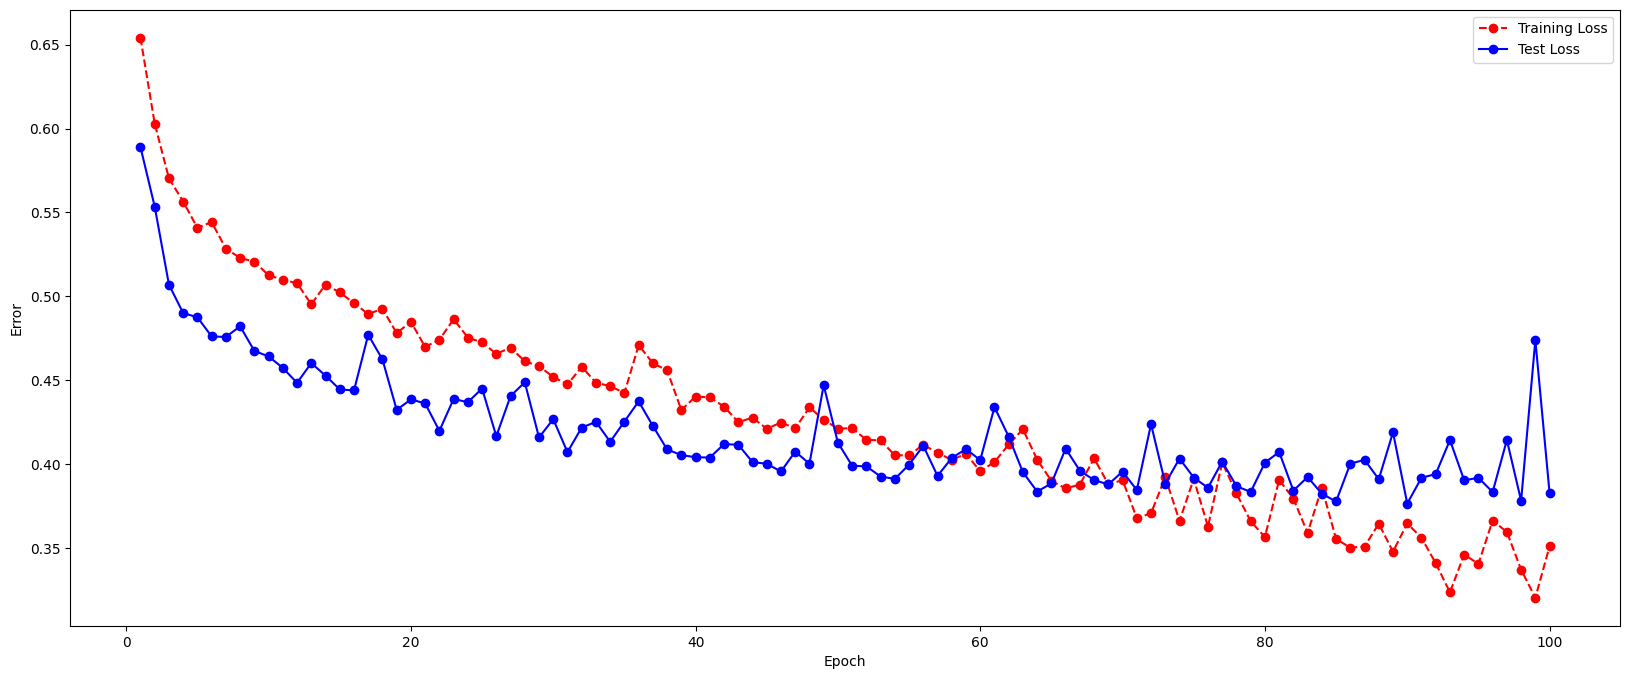

In [33]:
plt.plot(epochs_range, training_loss, 'r',marker="o",linestyle="--")
plt.plot(epochs_range, test_loss, 'b',marker="o",linestyle="-")
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.rcParams["figure.figsize"] = (20,8)
plt.show()

In [14]:
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"val_loss: {test_accuracy[0]}", f"val_accuracy: {test_accuracy[1]}")

y_i = len(y_values)
i = 0
true_values = 0
while (i < y_i):
    true_values += (1 if (y_test[i][0] == y_prediction[i][0] or y_test[i][1] == y_prediction[i][1]) else 0)
    i = i + 1 
    
print(f"El algoritmo acerto {true_values} veces sobre los {y_i} casos.")

val_loss: 0.40328726172447205 val_accuracy: 0.8150064945220947


NameError: name 'y_values' is not defined

In [77]:
'''
val_loss: 0.42675861716270447 val_accuracy: 0.7767857313156128
val_loss: 0.44326552748680115 val_accuracy: 0.7611607313156128
val_loss: 0.4475260078907013 val_accuracy: 0.7566964030265808
'''

'\nval_loss: 0.42675861716270447 val_accuracy: 0.7767857313156128\nval_loss: 0.44326552748680115 val_accuracy: 0.7611607313156128\nval_loss: 0.4475260078907013 val_accuracy: 0.7566964030265808\n'

#### Crossvalidation

In [57]:
X = np.array(X)
y = np.array(y)
print(f"X:{X.shape} y:{y.shape}")

X:(2236, 40) y:(2236, 2)


In [69]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


El bloque realizara el k fold cross validation dividiendolo en 5 folds, se uso los MSE.

In [28]:
# serialize model to JSON
model_json = model.to_json()
with open("model_5.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_5.h5")
print("Saved model to disk")

Saved model to disk
